In [3]:
import pandas as pd
import re
from datetime import datetime, timedelta

# ---------- CONFIG ----------
CSV_PATH = "GrandeInstav2.csv"   # change if the file lives elsewhere
TODAY     = datetime(2025, 6, 25)  # reference date (presentation day)
WINDOW    = 30                     # look-back window in days

# ---------- LOAD & PREP ----------
df = pd.read_csv(CSV_PATH)
df["PostDate"] = pd.to_datetime(df["PostDate"], dayfirst=True)

def has_nepali(text: str) -> bool:
    """True if caption contains any Devanagari (Nepali) character."""
    return bool(re.search(r"[\u0900-\u097F]", str(text)))

df["Nepali"]       = df["Caption"].apply(has_nepali)
df["Interactions"] = df["Likes"].fillna(0) + df["Comments"].fillna(0)

# ---------- METRIC FUNCTION ----------
def get_metrics(subset: pd.DataFrame, period_days: int) -> dict:
    n_posts = len(subset)
    mix_pct = (subset["ContentType"]
               .value_counts(normalize=True)
               .mul(100).round(1))
    return {
        "Posts": n_posts,
        "Posts per week": round(n_posts / (period_days / 7), 2) if n_posts else 0,
        "Reels %":        mix_pct.get("Reel", 0.0),
        "Images %":       mix_pct.get("Image", 0.0),
        "Multi-image %":  mix_pct.get("Post", 0.0),
        "Nepali caption %": round(subset["Nepali"].mean() * 100, 1) if n_posts else 0,
        "Avg interactions / post": round(subset["Interactions"].mean(), 1) if n_posts else 0,
        "Peak interactions": int(subset["Interactions"].max()) if n_posts else 0,
    }

# ---------- CALCULATE ----------
recent_df = df[df["PostDate"] >= TODAY - timedelta(days=WINDOW)]
recent_metrics = get_metrics(recent_df, WINDOW)

total_days = (df["PostDate"].max() - df["PostDate"].min()).days + 1
full_metrics = get_metrics(df, total_days)

# ---------- PRINT ----------
print("=== Last 30 Days ===")
for k, v in recent_metrics.items():
    print(f"{k:25}: {v}")

print("\n=== Entire Dataset ===")
for k, v in full_metrics.items():
    print(f"{k:25}: {v}")


=== Last 30 Days ===
Posts                    : 17
Posts per week           : 3.97
Reels %                  : 47.1
Images %                 : 35.3
Multi-image %            : 17.6
Nepali caption %         : 29.4
Avg interactions / post  : 8.8
Peak interactions        : 30

=== Entire Dataset ===
Posts                    : 40
Posts per week           : 2.0
Reels %                  : 60.0
Images %                 : 22.5
Multi-image %            : 17.5
Nepali caption %         : 35.0
Avg interactions / post  : 10.1
Peak interactions        : 47


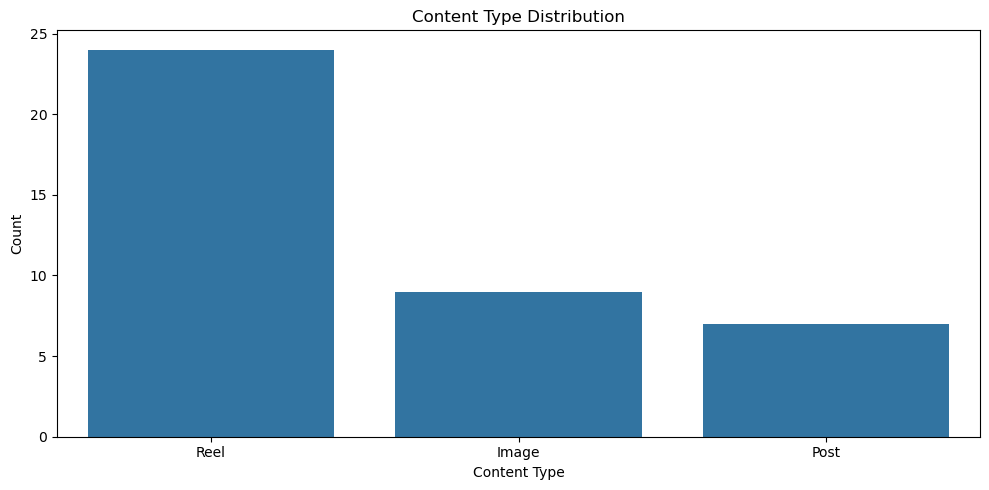

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime

# Load CSV
df = pd.read_csv("GrandeInstav2.csv")
df["PostDate"] = pd.to_datetime(df["PostDate"], dayfirst=True)

# Derived columns
df["Weekday"] = df["PostDate"].dt.day_name()
df["Month"] = df["PostDate"].dt.to_period("M")
df["Interactions"] = df["Likes"].fillna(0) + df["Comments"].fillna(0)

# Detect Nepali script
def has_nepali(text):
    return bool(re.search(r"[\u0900-\u097F]", str(text)))

df["Nepali"] = df["Caption"].apply(has_nepali)

# === PLOT 1: Content Type Count ===
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="ContentType", order=df["ContentType"].value_counts().index)
plt.title("Content Type Distribution")
plt.xlabel("Content Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



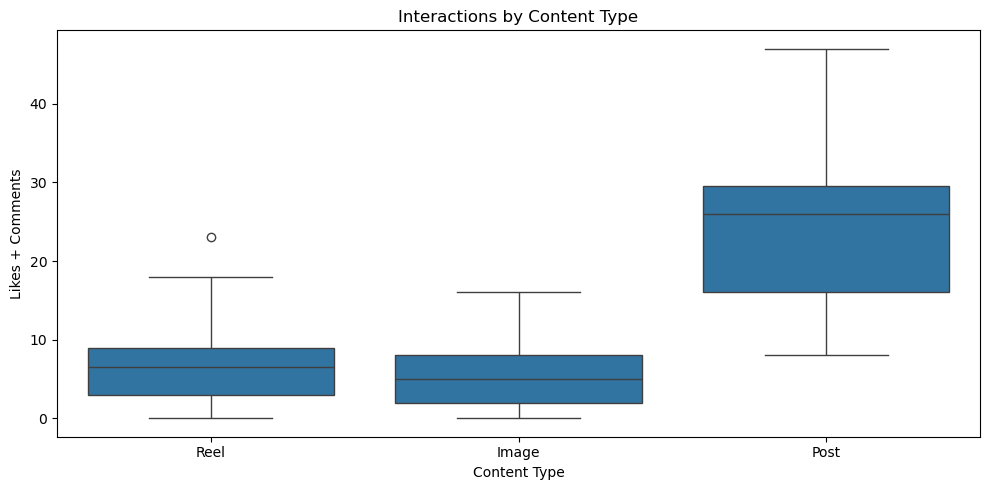

In [6]:
# === PLOT 2: Engagement by Content Type ===
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="ContentType", y="Interactions")
plt.title("Interactions by Content Type")
plt.xlabel("Content Type")
plt.ylabel("Likes + Comments")
plt.tight_layout()
plt.show()


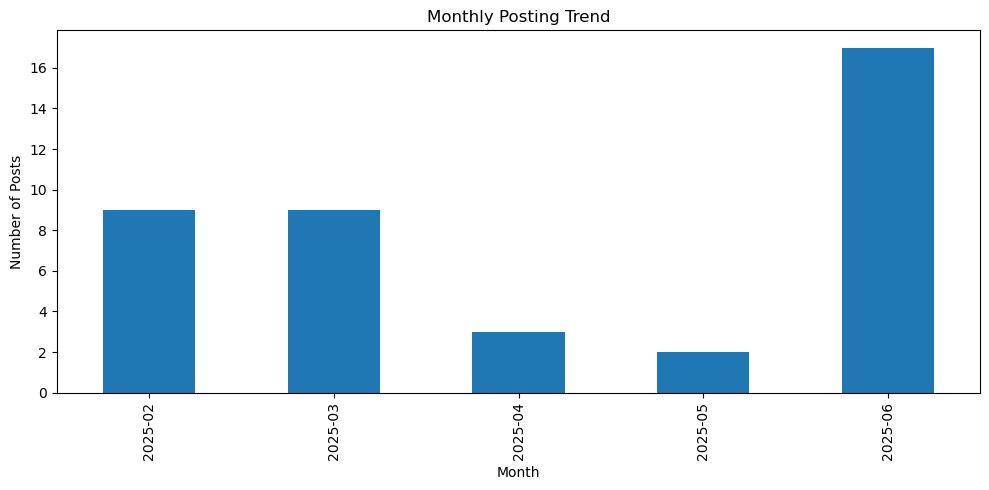

In [7]:

# === PLOT 4: Monthly Post Trend ===
plt.figure(figsize=(10, 5))
df["Month"].value_counts().sort_index().plot(kind="bar")
plt.title("Monthly Posting Trend")
plt.xlabel("Month")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.show()




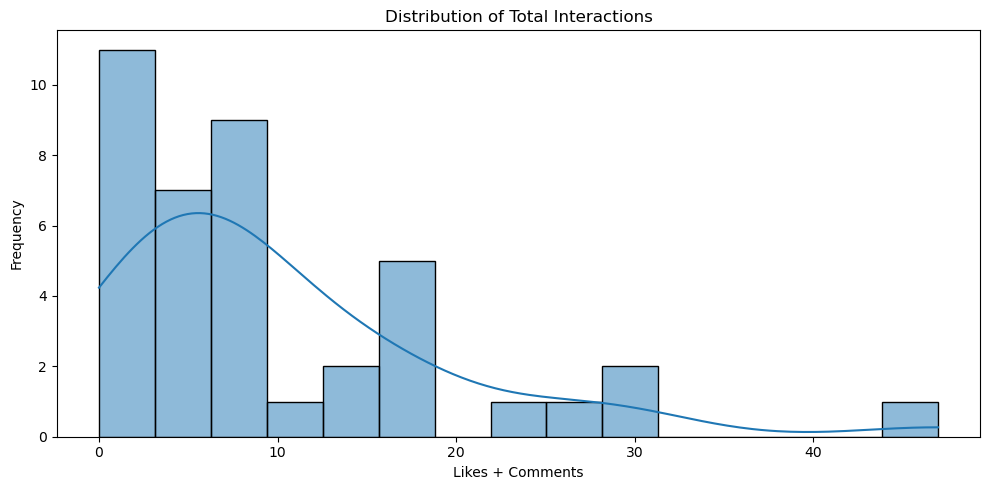

In [8]:
# === PLOT 5: Interaction Distribution ===
plt.figure(figsize=(10, 5))
sns.histplot(df["Interactions"], bins=15, kde=True)
plt.title("Distribution of Total Interactions")
plt.xlabel("Likes + Comments")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


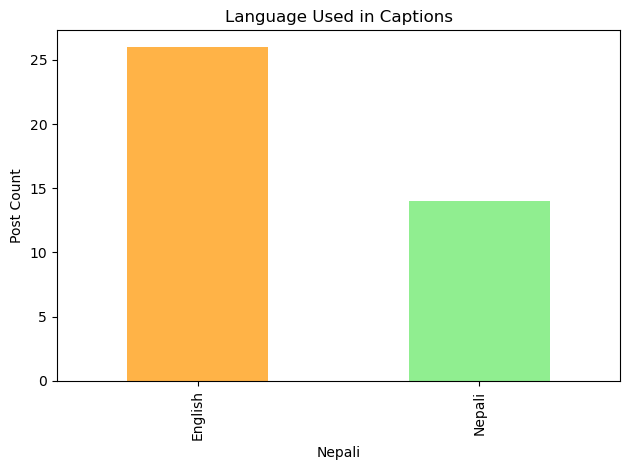

In [9]:

# === PLOT 6: Nepali vs English ===
lang_counts = df["Nepali"].value_counts().rename(index={True: "Nepali", False: "English"})
lang_counts.plot(kind="bar", color=["#ffb347", "#90ee90"])
plt.title("Language Used in Captions")
plt.ylabel("Post Count")
plt.tight_layout()
plt.show()

In [10]:
import pandas as pd
import re

# Load data
df = pd.read_csv("GrandeInstav2.csv")
df["PostDate"] = pd.to_datetime(df["PostDate"], dayfirst=True)
df["Interactions"] = df["Likes"].fillna(0) + df["Comments"].fillna(0)

# Detect Nepali
def has_nepali(text):
    return bool(re.search(r"[\u0900-\u097F]", str(text)))
df["Nepali"] = df["Caption"].apply(has_nepali)

# Caption length buckets
df["CaptionLength"] = df["Caption"].fillna("").apply(len)
df["LengthGroup"] = pd.cut(df["CaptionLength"], bins=[0, 50, 100, 150, 300, 1000],
                           labels=["0–50", "51–100", "101–150", "151–300", "300+"])

# 1. Performance by content type
content_perf = df.groupby("ContentType")["Interactions"].agg(["count", "mean", "median", "max"]).round(1)

# 2. Performance by caption length
length_perf = df.groupby("LengthGroup")["Interactions"].agg(["count", "mean", "median", "max"]).round(1)

# 3. Performance by language
lang_perf = df.groupby(df["Nepali"].map({True: "Nepali", False: "English"}))["Interactions"].agg(["count", "mean", "median", "max"]).round(1)

# 4. Performance by theme keyword
themes = {
    "MedTalk": df[df["Caption"].str.contains("MedTalk", case=False, na=False)],
    "Visit": df[df["Caption"].str.contains("visit", case=False, na=False)],
    "Training": df[df["Caption"].str.contains("train", case=False, na=False)],
    "Awareness": df[df["Caption"].str.contains("awareness|day", case=False, na=False)],
}

theme_perf = pd.DataFrame({
    theme: data["Interactions"].agg(["count", "mean", "median", "max"]).round(1)
    for theme, data in themes.items()
}).T

# Print results
print("\n=== Interactions by Content Type ===")
print(content_perf)

print("\n=== Interactions by Caption Length ===")
print(length_perf)

print("\n=== Interactions by Language ===")
print(lang_perf)

print("\n=== Interactions by Theme Keyword ===")
print(theme_perf)



=== Interactions by Content Type ===
             count  mean  median   max
ContentType                           
Image            9   6.2     5.0  16.0
Post             7  24.6    26.0  47.0
Reel            24   7.3     6.5  23.0

=== Interactions by Caption Length ===
             count  mean  median   max
LengthGroup                           
0–50             2   5.5     5.5   8.0
51–100           2   0.0     0.0   0.0
101–150          5   2.6     2.0   6.0
151–300         15  10.9     8.0  30.0
300+            14  14.1    14.5  47.0

=== Interactions by Language ===
         count  mean  median   max
Nepali                            
English     26  12.0     8.0  47.0
Nepali      14   6.5     6.5  18.0

=== Interactions by Theme Keyword ===
           count  mean  median   max
MedTalk      0.0   NaN     NaN   NaN
Visit        0.0   NaN     NaN   NaN
Training     3.0  20.3    16.0  29.0
Awareness    6.0  13.5    12.0  26.0


/var/folders/vf/64r8j3px5m7_0cwl_br4gt2c0000gn/T/ipykernel_42925/2076137940.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_perf = df.groupby("LengthGroup")["Interactions"].agg(["count", "mean", "median", "max"]).round(1)


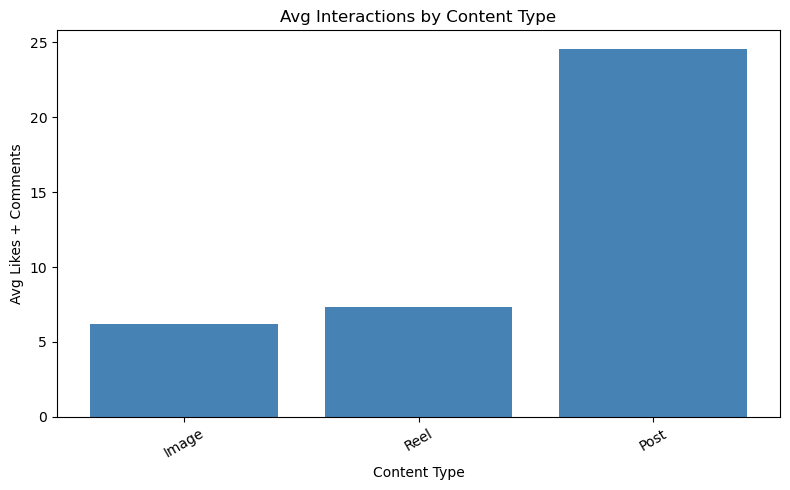

/var/folders/vf/64r8j3px5m7_0cwl_br4gt2c0000gn/T/ipykernel_42925/2305529039.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  caption_perf = df.groupby("LengthGroup")["Interactions"].mean().sort_index()


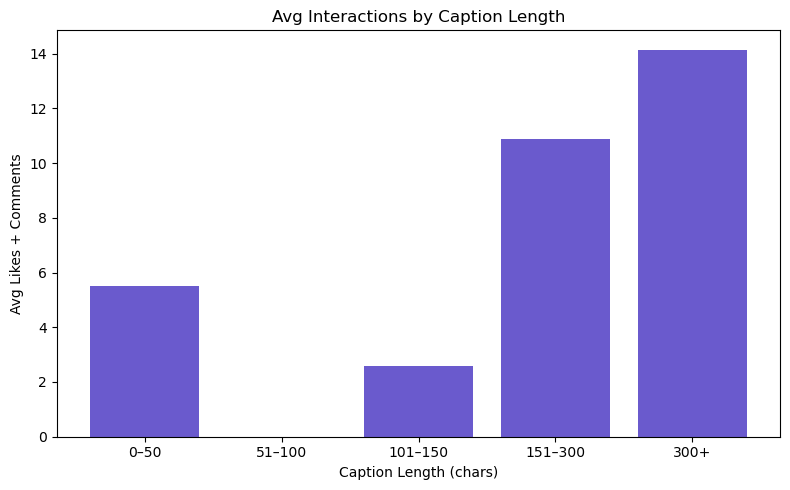

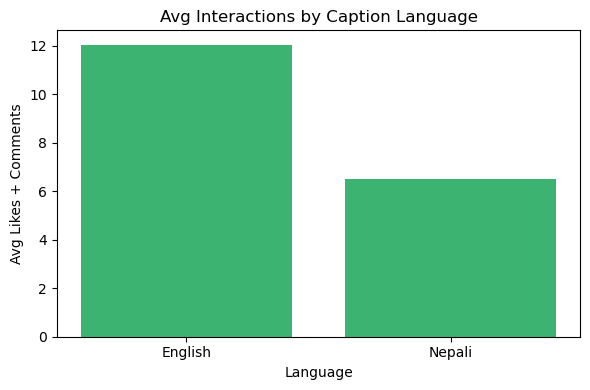

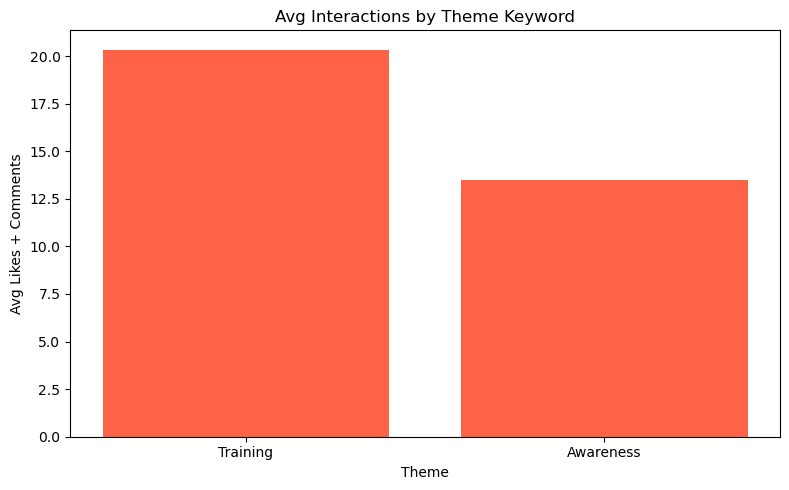

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Load data
df = pd.read_csv("GrandeInstav2.csv")
df["PostDate"] = pd.to_datetime(df["PostDate"], dayfirst=True)
df["Interactions"] = df["Likes"].fillna(0) + df["Comments"].fillna(0)

# Detect Nepali captions
def has_nepali(text):
    return bool(re.search(r"[\u0900-\u097F]", str(text)))
df["Nepali"] = df["Caption"].apply(has_nepali)

# Caption length group
df["CaptionLength"] = df["Caption"].fillna("").apply(len)
df["LengthGroup"] = pd.cut(df["CaptionLength"], bins=[0, 50, 100, 150, 300, 1000],
                           labels=["0–50", "51–100", "101–150", "151–300", "300+"])


# === 1. Average Interactions by Content Type ===
content_perf = df.groupby("ContentType")["Interactions"].mean().sort_values()

plt.figure(figsize=(8, 5))
plt.bar(content_perf.index, content_perf.values, color="steelblue")
plt.title("Avg Interactions by Content Type")
plt.xlabel("Content Type")
plt.ylabel("Avg Likes + Comments")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


# === 2. Average Interactions by Caption Length ===
caption_perf = df.groupby("LengthGroup")["Interactions"].mean().sort_index()

plt.figure(figsize=(8, 5))
plt.bar(caption_perf.index.astype(str), caption_perf.values, color="slateblue")
plt.title("Avg Interactions by Caption Length")
plt.xlabel("Caption Length (chars)")
plt.ylabel("Avg Likes + Comments")
plt.tight_layout()
plt.show()


# === 3. Average Interactions by Language ===
lang_perf = df.groupby(df["Nepali"].map({True: "Nepali", False: "English"}))["Interactions"].mean()

plt.figure(figsize=(6, 4))
plt.bar(lang_perf.index, lang_perf.values, color="mediumseagreen")
plt.title("Avg Interactions by Caption Language")
plt.xlabel("Language")
plt.ylabel("Avg Likes + Comments")
plt.tight_layout()
plt.show()


# === 4. Theme Keyword Performance ===
themes = {
    "MedTalk": df[df["Caption"].str.contains("MedTalk", case=False, na=False)],
    "Visit": df[df["Caption"].str.contains("visit", case=False, na=False)],
    "Training": df[df["Caption"].str.contains("train", case=False, na=False)],
    "Awareness": df[df["Caption"].str.contains("awareness|day", case=False, na=False)],
}
theme_means = {k: v["Interactions"].mean() for k, v in themes.items()}

plt.figure(figsize=(8, 5))
plt.bar(theme_means.keys(), theme_means.values(), color="tomato")
plt.title("Avg Interactions by Theme Keyword")
plt.xlabel("Theme")
plt.ylabel("Avg Likes + Comments")
plt.tight_layout()
plt.show()


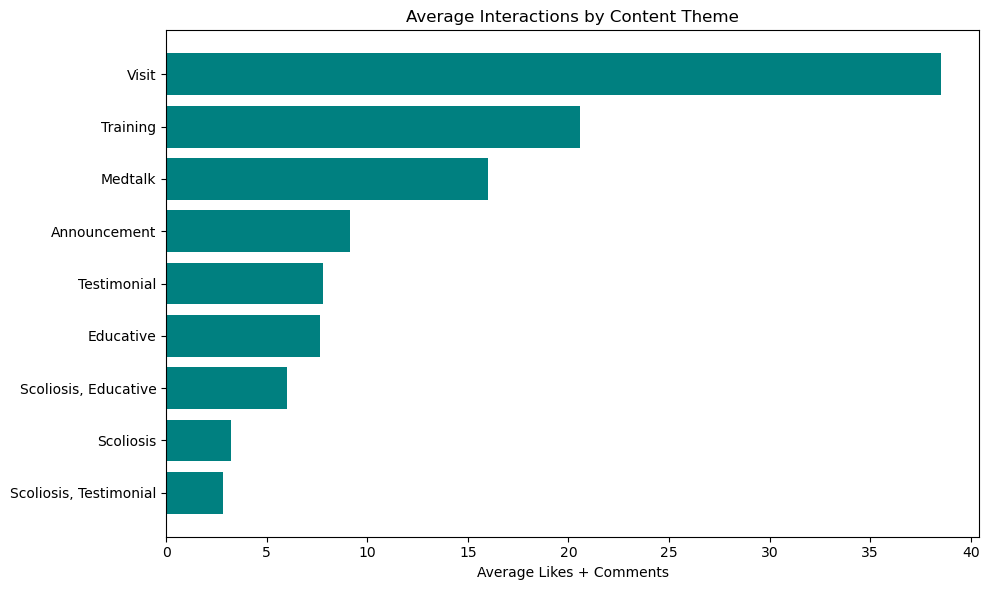

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("GrandeInstav2.csv")
df["PostDate"] = pd.to_datetime(df["PostDate"], dayfirst=True)
df["Interactions"] = df["Likes"].fillna(0) + df["Comments"].fillna(0)
df["ContentTheme"] = df["ContentTheme"].fillna("Unknown").str.title().str.strip()

# Group and summarize
theme_perf = df.groupby("ContentTheme")["Interactions"].agg(["count", "mean", "median", "max"]).sort_values("mean", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(theme_perf.index, theme_perf["mean"], color="teal")
plt.xlabel("Average Likes + Comments")
plt.title("Average Interactions by Content Theme")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [13]:
import pandas as pd

# Load current and previous data
df_now = pd.read_csv("GrandeInstav2.csv")
df_last = pd.read_csv("GrandeInsta.csv")

for df in [df_now, df_last]:
    df["PostDate"] = pd.to_datetime(df["PostDate"], dayfirst=True)
    df["Interactions"] = df["Likes"].fillna(0) + df["Comments"].fillna(0)
    df["ContentTheme"] = df["ContentTheme"].fillna("Unknown").str.title().str.strip()

def get_theme_perf(df):
    return df.groupby("ContentTheme")["Interactions"].agg(
        count='count', mean='mean', median='median', max='max'
    ).round(1)

perf_now = get_theme_perf(df_now)
perf_last = get_theme_perf(df_last)

# Merge results for side-by-side comparison
comparison = perf_now.join(
    perf_last, lsuffix="_now", rsuffix="_last", how="outer"
).fillna(0)

# Print comparison for each theme
for theme, row in comparison.iterrows():
    print(f"\n### Theme: {theme}")
    print(f"- Current: count={int(row['count_now'])}, mean={row['mean_now']}, median={row['median_now']}, max={int(row['max_now'])}")
    print(f"- Last week: count={int(row['count_last'])}, mean={row['mean_last']}, median={row['median_last']}, max={int(row['max_last'])}")



### Theme: Announcement
- Current: count=7, mean=9.1, median=6.0, max=23
- Last week: count=7, mean=9.1, median=6.0, max=23

### Theme: Educative
- Current: count=9, mean=7.7, median=8.0, max=18
- Last week: count=9, mean=7.7, median=8.0, max=18

### Theme: Medtalk
- Current: count=1, mean=16.0, median=16.0, max=16
- Last week: count=0, mean=0.0, median=0.0, max=0

### Theme: Scoliosis
- Current: count=4, mean=3.2, median=2.5, max=8
- Last week: count=3, mean=1.7, median=2.0, max=3

### Theme: Scoliosis, Educative
- Current: count=1, mean=6.0, median=6.0, max=6
- Last week: count=0, mean=0.0, median=0.0, max=0

### Theme: Scoliosis, Testimonial
- Current: count=6, mean=2.8, median=1.5, max=10
- Last week: count=5, mean=3.0, median=1.0, max=10

### Theme: Testimonial
- Current: count=5, mean=7.8, median=8.0, max=13
- Last week: count=5, mean=7.8, median=8.0, max=13

### Theme: Training
- Current: count=5, mean=20.6, median=16.0, max=29
- Last week: count=5, mean=20.6, median=16.0, max=